We want to have a better understanding of the representation of sea ice in the ECCO model (reanalysis). The goal of this notebook is to plot -

- ECCO sea ice velocity and ERA-Interim wind velocity
- ECCO sea ice thickness
- Relationship between the sea ice thickness and transfer coefficient 
during a similar time frame (1992-2017).

In this process, we will be able to understand how wind force influences sea ice in the model. In other words,  we will be able to know how sensitive the sea ice is to the presence of wind.  

<hr>

# Section 1

The primary goal for this section is to learn how to load one year sea ice velocity dataset and convert the model u and v directional velocity to gloabl zonal and meridional velocity. Also, to plot the velocity vectors for that one year. We chose 1992 as a sample year for this notebook. 

- [x] Load one year data 
- [x] Convert model u ($u_x$) and model v ($v_y$) to zonal ($u_{\lambda}$) and meridional ($v_{\phi}$) velocity components
- [x] Add $u_{\lambda}$, $v_{\phi}$, and c in the `ecco_ds` where, c = $\sqrt{u_{\lambda}^2 + v_{\phi}^2}$
- [x] Show sea ice velocity (quiver arrows) for one year

<hr>

## Load data and set up geometry

<div class="alert alert-block alert-info">
<b>Step 1:</b> First, import all necessary libraries and set up directories and ECCO grid systems</div>

In [2]:
%%time
import numpy as np
import xarray as xr
import os
import sys
import glob  
import netCDF4  
import pandas as pd  
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
from datetime import datetime
from os.path import join,expanduser,exists,split
import cartopy as cartopy
import importlib
import matplotlib.cm as cm
from pathlib import Path
from pprint import pprint
import xgcm as xgcm
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

import warnings


warnings.filterwarnings('ignore')
%matplotlib inline

CPU times: user 6.52 s, sys: 452 ms, total: 6.97 s
Wall time: 7.62 s


<code style="background:yellow;color:black">Select either Wilhelmus Shared Lab Drive or my computer.</code>

In [3]:
# Wilhelmus Shared Lab Drive
# user_home_dir = expanduser('/Volumes/ENG_Wilhelmus_Shared/group/ECCO Sea Ice Validation/')
# My computer
user_home_dir = expanduser('/Users/aahmed78/Desktop/ECCO/ECCO Sea Ice Velocity/')
sys.path.append(join(user_home_dir,'ECCO-v4-Python-Tutorial'))
sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco
from ecco_v4_py import get_llc_grid as get_llc_grid
from ecco_v4_py import plot_proj_to_latlon_grid
import ecco_access as ea

<code style="background:yellow;color:black">Set up XGCM grid systems.</code>

In [4]:
# Wilhelmus Shared Lab Drive
# ecco_dir = expanduser('/Volumes/ENG_Wilhelmus_Shared/group/ECCO Sea Ice Validation/data/')
# My computer
ecco_dir = '/Users/aahmed78/Desktop/ECCO/ECCO Sea Ice Velocity/data/'
os.chdir(ecco_dir)
! pwd
print("\n")

ecco_grid = xr.open_dataset('GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc') 
print("Geometry variables: ",list(ecco_grid.data_vars))
print("\n")

# Make the XGCM object
XGCM_grid = get_llc_grid(ecco_grid)

# look at the XGCM object.
print(XGCM_grid)

/Users/aahmed78/Desktop/ECCO/ECCO Sea Ice Velocity/data


Geometry variables:  ['CS', 'SN', 'rA', 'dxG', 'dyG', 'Depth', 'rAz', 'dxC', 'dyC', 'rAw', 'rAs', 'drC', 'drF', 'PHrefC', 'PHrefF', 'hFacC', 'hFacW', 'hFacS', 'maskC', 'maskW', 'maskS']


<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Z Axis (not periodic, boundary=None):
  * center   k --> left
  * right    k_u --> center
  * left     k_l --> center
  * outer    k_p1 --> center


## Sea ice velocity

<div class="alert alert-block alert-info">
<b>Step 2:</b> Now, get the sea ice velocity data from NetCDF files and merge with ECCO geometry in a single dataset called "ecco_ds"</div>

In [5]:
# Load the NetCDF file using xarray (for simplicity, we are using only one year --> year = 1992)
year = 1992
file_name = ecco_dir + 'ecco_sea_ice_velocity_{y}.nc'.format(y=year)
ecco_ds = xr.open_dataset(file_name) # sea ice velocity data
ecco_ds = xr.merge((ecco_ds , ecco_grid)).compute()
print(list(ecco_ds.data_vars))
ecco_ds

['SIuice', 'SIvice', 'CS', 'SN', 'rA', 'dxG', 'dyG', 'Depth', 'rAz', 'dxC', 'dyC', 'rAw', 'rAs', 'drC', 'drF', 'PHrefC', 'PHrefF', 'hFacC', 'hFacW', 'hFacS', 'maskC', 'maskW', 'maskS']


<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 366, nv: 2,
                nb: 4, k: 50, k_u: 50, k_l: 50, k_p1: 51)
Coordinates: (12/22)
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 1992-01-01T18:00:00 ... 1992-12-31T12:00:00
    ...         ...
  * k_p1       (k_p1) int32 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
    Z          (k) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
    Zp1        (k_p1) float32 0.0 -10.0 -20.0 ... -5.678e+03 -6.134e+03
    Zu         (k_u) float32 -10.0 -20.0 -30.0 ... -5.678e+03 -6.134e+03
    Zl         (k_l) float32 0.0 -10.0 -20.0 ... -5.244e+03 -5.678e+03
    Z_bnds     (k, nv) float32 0.0 -10.0 -10.0 ... -5.678e+03 -6.134e+03
Dimensions without coordinates: nv, nb
Data variables: (12/23)
    SIuice     (time, tile, j, i_g) float32 nan nan nan nan ... nan nan nan nan
    SIvice     (time, tile, j_g, i) float32 nan nan nan nan ... nan nan nan nan
    CS         (tile, j, i) float32 0.06158 0.06675 0.07293 ... -0.9854 -0.9984
    SN         (tile, j, i) float32 -0.9981 -0.9978 -0.9973 ... -0.1705 -0.05718
    rA         (tile, j, i) float32 3.623e+08 3.633e+08 ... 3.685e+08 3.611e+08
    dxG        (tile, j_g, i) float32 1.558e+04 1.559e+04 ... 2.36e+04 2.314e+04
    ...         ...
    hFacC      (k, tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hFacW      (k, tile, j, i_g) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    hFacS      (k, tile, j_g, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    maskC      (k, tile, j, i) bool False False False ... False False False
    maskW      (k, tile, j, i_g) bool False False False ... False False False
    maskS      (k, tile, j_g, i) bool False False False ... False False False
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1D
    time_coverage_end:            1992-01-02T00:00:00
    time_coverage_resolution:     P1D
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea-Ice Velocity - Daily Mean llc90 Gr...
    uuid:                         a029ca02-4050-11eb-ac63-0cc47a3f479b

<div class="alert alert-block alert-warning">
<b>Note:</b> We only chose 5 tiles out of 13. Rest of the tiles are not considerd because they do not contain Arctic ocean. Additionally, this method significantly reduces the data size.
</div>

<code style="background:yellow;color:black">At this point, delete some variable so the dataset can breathe.</code>

In [6]:
# List of variables to delete
vars_to_delete = ['rA', 'dxG', 'dyG', 'rAz', 'dxC', 'dyC', 'rAw', 'rAs', 
                  'drC', 'drF', 'PHrefC', 'PHrefF', 'hFacC', 'hFacW', 'hFacS']

# Drop the variables from the dataset
ecco_ds = ecco_ds.drop_vars(vars_to_delete)


In [7]:
ecco_ds.close()

<code style="background:yellow;color:black">Have a look at all the tiles by plotting the u_x.</code>

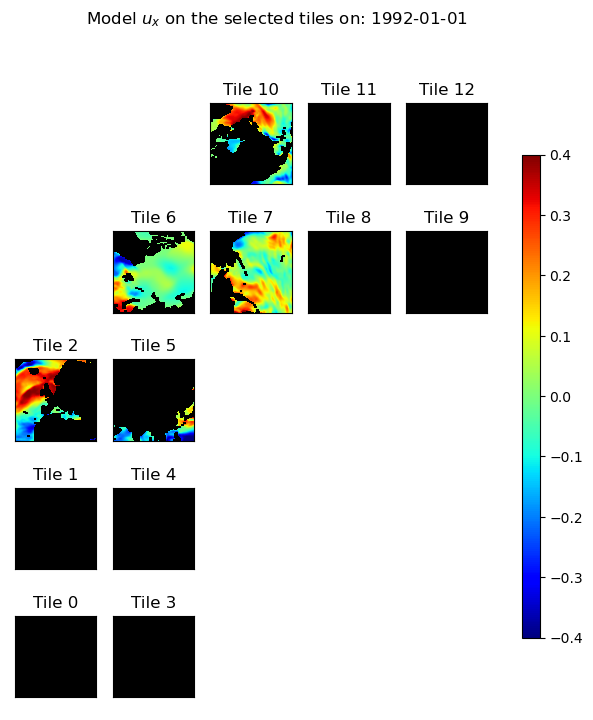

In [8]:
T = 0; # day = 1
jet_colMap_w = cm.jet
jet_colMap_w.set_bad(color='black')
ecco.plot_tiles(ecco_ds.SIuice.isel(time=T), show_tile_labels=True,
                cmin=-0.4, cmax=0.4, cmap=jet_colMap_w,
                fig_size=7, show_colorbar=True)

plt.suptitle('Model $u_x$ on the selected tiles on: ' + str(ecco_ds.time[T].values)[:10])
plt.show()


## Velocity conversion

<div class="alert alert-block alert-info">
<b>Step 3:</b> We need to convert the model u and v velocity to zonal and meridional velocity. Or simply, $u_x$ and $u_y$ to $\lambda$ and $\phi$ </div>

<code style="background:yellow;color:black">First, mask the land pixels</code>

In [9]:
u_x = ecco_ds.SIuice.copy(deep=True)
v_y = ecco_ds.SIvice.copy(deep=True)

# set land points to nan so that we don't get big gradients between ocean and land
# ... the wet/dry mask for 'u' points is in the 'maskW' field
# ... the wet/dry mask for 'v' points is in the 'maskS' field
nan_land_mask_W = ecco_ds.maskW.where(ecco_ds.maskW.isel(k=0) > 0);
nan_land_mask_S = ecco_ds.maskS.where(ecco_ds.maskS.isel(k=0) > 0);
    
# mask land points with nan
u_x = u_x*nan_land_mask_W.isel(k=0)
v_y = v_y*nan_land_mask_S.isel(k=0)

<code style="background:yellow;color:black">Second, calculate the zonal and meridional components of flow from the u_x and v_y components</code>

In [10]:
# u_x and v_y are located at the model's 'u' and 'v' points, respectively.
# interpolate the vectors to the cell centers at i,j
vec_u_to_ij = XGCM_grid.interp_2d_vector({'X': u_x, 'Y': v_y},boundary='fill')

# vec_u_to_ij is a dictionary holding the interpolated vectors with the 'X' and 'Y' keys.

# rotate the interpolated vectors to the zonal (lambda) and meridional (phi) basis
# Add the zonal components of the 'X' and 'Y' vectors
u_lambda       = vec_u_to_ij['X']*ecco_ds['CS'] - vec_u_to_ij['Y']*ecco_ds['SN']

# Add the meridional components
v_phi          = vec_u_to_ij['X']*ecco_ds['SN'] + vec_u_to_ij['Y']*ecco_ds['CS']

<code style="background:yellow;color:black">Third, check the dimensions of all variables that we have just updated/added.</code>

In [11]:
# confirm that the field is indeed in the native grid format and tracer cell point [dimensions 'tile','i','j']
# (13 tiles of 90x90)
print(f'\nu_x dimensions:  {u_x.dims}')
print(f'u_x shape:       {u_x.shape}')
print(f'\nv_y dimensions: {v_y.dims}')
print(f'v_y shape:       {v_y.shape}')
print(f'\nu_lambda dimensions: {u_lambda.dims}')
print(f'u_lambda shape:       {u_lambda.shape}')
print(f'\nv_phi dimensions: {v_phi.dims}')
print(f'v_phi shape:       {v_phi.shape}')


u_x dimensions:  ('time', 'tile', 'j', 'i_g')
u_x shape:       (366, 13, 90, 90)

v_y dimensions: ('time', 'tile', 'j_g', 'i')
v_y shape:       (366, 13, 90, 90)

u_lambda dimensions: ('time', 'tile', 'j', 'i')
u_lambda shape:       (366, 13, 90, 90)

v_phi dimensions: ('time', 'tile', 'j', 'i')
v_phi shape:       (366, 13, 90, 90)


<div class="alert alert-block alert-success">
<b>Success:</b> We are showing the converted zonal velocity for all selected tiles (day = 1).
</div>

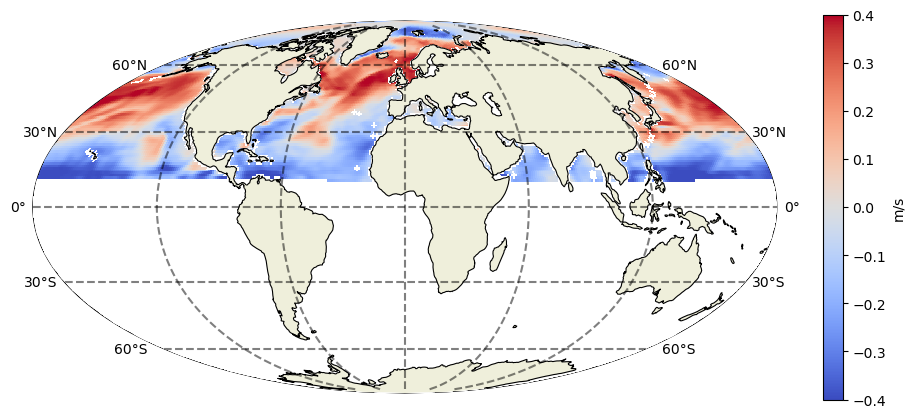

In [12]:
coolwarm_colMap_w = cm.coolwarm
coolwarm_colMap_w.set_bad(color='white')

plt.figure(figsize=[12,5]);
X = plot_proj_to_latlon_grid(ecco_ds.XC, ecco_ds.YC, u_lambda.isel(time=0), 
                             user_lon_0=0, projection_type='Mollweide', 
                             dx=.25, dy=.25, mapping_method='nearest_neighbor', 
                             radius_of_influence=112000, plot_type='pcolormesh', 
                             circle_boundary=False, cmap=coolwarm_colMap_w, 
                             cmin=-0.4, cmax=0.4, lat_lim=50, parallels=None, 
                             show_coastline=True, show_colorbar=True, show_land=True, 
                             show_grid_lines=True, show_grid_labels=True, 
                             show_coastline_over_data=True, show_land_over_data=True, 
                             grid_linewidth=1.5, grid_linestyle='--', colorbar_label='m/s', 
                             colorbar_location=None, subplot_grid=None, less_output=True)


## Velocity magnitude

<div class="alert alert-block alert-info">
<b>Step 4:</b> Calculate the speed, c from $u_{\lambda}$ and $v_{\phi}$. Where, $u_{\lambda}$ = zonal velocity and $v_{\phi}$ = meridional velocity
We can do it simply, by taking the square root of the zonal and meridional velocities. Therefore, c = $\sqrt{u_{\lambda}^2 + v_{\phi}^2}$ </div>

In [13]:
# Calculate the magnitude of velocity for color mapping
c = np.sqrt(u_lambda**2 + v_phi**2)
c = np.where(~np.isfinite(c), np.nan, c)
# c = np.where(c > 0.5, 0.5, c)

print(f'c shape:       {c.shape}')

c shape:       (366, 13, 90, 90)


In [14]:
ecco_ds = ecco_ds.assign(u_lambda=u_lambda,
                         v_phi=v_phi, 
                         c=(("time", "tile", "j", "i"), c))
# update the variable names
u_lambda.name = 'u_lambda'
v_phi.name = 'v_phi'

u_lambda.attrs.update({'long_name':'zonal velocity'})
v_phi.attrs.update({'long_name':'meridional velocity'})

#The gradients have units psu/m
u_lambda.attrs.update({'units':'m s-1'})
v_phi.attrs.update({'units':'m s-1'})
ecco_ds

<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 366, nv: 2,
                nb: 4, k: 50, k_u: 50, k_l: 50, k_p1: 51)
Coordinates: (12/22)
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 1992-01-01T18:00:00 ... 1992-12-31T12:00:00
    ...         ...
  * k_p1       (k_p1) int32 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
    Z          (k) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
    Zp1        (k_p1) float32 0.0 -10.0 -20.0 ... -5.678e+03 -6.134e+03
    Zu         (k_u) float32 -10.0 -20.0 -30.0 ... -5.678e+03 -6.134e+03
    Zl         (k_l) float32 0.0 -10.0 -20.0 ... -5.244e+03 -5.678e+03
    Z_bnds     (k, nv) float32 0.0 -10.0 -10.0 ... -5.678e+03 -6.134e+03
Dimensions without coordinates: nv, nb
Data variables:
    SIuice     (time, tile, j, i_g) float32 nan nan nan nan ... nan nan nan nan
    SIvice     (time, tile, j_g, i) float32 nan nan nan nan ... nan nan nan nan
    CS         (tile, j, i) float32 0.06158 0.06675 0.07293 ... -0.9854 -0.9984
    SN         (tile, j, i) float32 -0.9981 -0.9978 -0.9973 ... -0.1705 -0.05718
    Depth      (tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    maskC      (k, tile, j, i) bool False False False ... False False False
    maskW      (k, tile, j, i_g) bool False False False ... False False False
    maskS      (k, tile, j_g, i) bool False False False ... False False False
    u_lambda   (time, tile, j, i) float64 nan nan nan nan ... nan nan nan nan
    v_phi      (time, tile, j, i) float64 nan nan nan nan ... nan nan nan nan
    c          (time, tile, j, i) float64 nan nan nan nan ... nan nan nan nan
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1D
    time_coverage_end:            1992-01-02T00:00:00
    time_coverage_resolution:     P1D
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea-Ice Velocity - Daily Mean llc90 Gr...
    uuid:                         a029ca02-4050-11eb-ac63-0cc47a3f479b

<code style="background:yellow;color:black">Now, compare between the speed and u_x and u_y.</code>

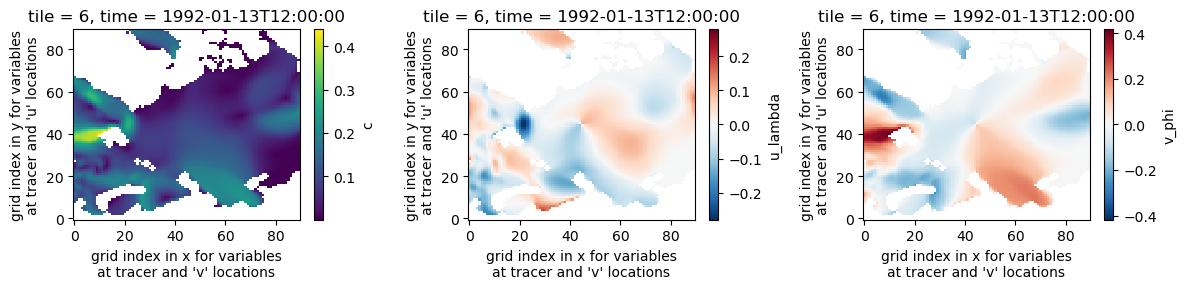

In [15]:
# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
T = 12;
# Plot on the first subplot
ecco_ds.c.isel(time=T, tile=6).plot(ax=axes[0], add_colorbar=True)

# Plot on the first subplot
ecco_ds.u_lambda.isel(time=T, tile=6).plot(ax=axes[1], add_colorbar=True)

# Plot on the second subplot
ecco_ds.v_phi.isel(time=T, tile=6).plot(ax=axes[2], add_colorbar=True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

<code style="background:yellow;color:black">Plot the velocity vectors.</code>

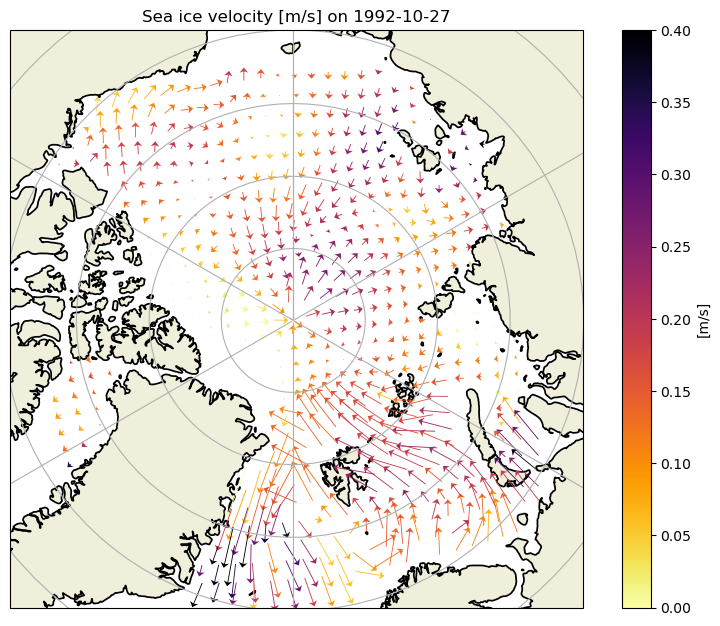

In [16]:
T = 300 # day 300
# Plot setup
f, ax = plt.subplots(1, 1, figsize=[10, 7.5], subplot_kw={'projection': ccrs.Stereographic(central_latitude=90)})

vector_crs = ccrs.PlateCarree()

# Arctic region extent (approximate)
ax.set_extent([-180, 180, 70, 90], crs=ccrs.PlateCarree())

# Normalize color range
norm = mcolors.Normalize(vmin=0, vmax=0.4)

# Quiver plot
h = ax.quiver(ecco_ds.XC.isel(tile=6).values[::3, ::3].ravel(),
              ecco_ds.YC.isel(tile=6).values[::3, ::3].ravel(),
              ecco_ds.u_lambda.isel(time=0, tile=6).values[::3, ::3].ravel(),
              ecco_ds.v_phi.isel(time=0, tile=6).values[::3, ::3].ravel(),
              c[T,6,:,:][::3, ::3].ravel(),  # Use 'c' for color mapping
              scale=5,
              transform=vector_crs,
              width=0.0015, 
              cmap='inferno_r', headwidth=10, headlength=6, norm=norm)

# Add land feature and gridlines
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', linewidth = 1.25)
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        linewidth = 1.75,
                                        facecolor=cfeature.COLORS['land'])
#ax.add_feature(land_50m)
ax.gridlines(draw_labels=False)

# Colorbar
f.colorbar(h, orientation='vertical', label='[m/s]')

# Title
ax.set_title('Sea ice velocity [m/s] on ' + str(ecco_ds.time[T].values)[:10])
plt.show()


In [17]:
ecco_ds.close()

<hr>

# Section 2

The primary goal of this section is to apply mask (SIC>0) to the sea ice velocity that we have calculated in `Section 1`. The reason being, the ECCO team forgot to apply SIC mask in the `SIuice` and `SIvice` variables and therefore, without the mask the plots show "sea ice" velocity all-around the globe. 

- [x] Load one year sea ice concentration (SIC) and sea ice thickness (SIT) data
- [x] Apply mask (SIC > 0) to the variables of `ecco_ds` where sea ice velocity is present, i.e., $u_{\lambda}$, $v_{\phi}$, and c
- [x] update `ecco_ds` with masked sea ice velocity
- [x] Group `ecco_ds` by seasons and month
- [x] Plot seasonal and monthly sea ice velocity

## Load and merge SIC data

<div class="alert alert-block alert-info">
<b>Step 1:</b> First, load the SIC and SIT files and merge them with `ecco_ds`</div>

In [18]:
# Wilhelmus Shared Lab Drive
# ecco_dir = expanduser('/Volumes/ENG_Wilhelmus_Shared/group/ECCO Sea Ice Validation/data/')
# My computer
ecco_dir = '/Users/aahmed78/Desktop/ECCO/ECCO Daily Sea Ice Concentration/'
os.chdir(ecco_dir)
! pwd
print("\n")


/Users/aahmed78/Desktop/ECCO/ECCO Daily Sea Ice Concentration




In [19]:
# Load the NetCDF file using xarray (for simplicity, we are using only one year --> year = 1992)
year = 1992
file_name = ecco_dir + 'ecco_sea_ice_concentration_{y}.nc'.format(y=year)
ds1 = xr.open_dataset(file_name) # sea ice velocity data
ecco_ds = xr.merge((ecco_ds , ds1)).compute()

print(list(ecco_ds.data_vars))

['SIuice', 'SIvice', 'CS', 'SN', 'Depth', 'maskC', 'maskW', 'maskS', 'u_lambda', 'v_phi', 'c', 'SIarea', 'SIheff', 'SIhsnow', 'sIceLoad']


In [20]:
ecco_ds.close()

<code style="background:yellow;color:black">`ecco_ds` now contains all key variables, including sea ice velocities (model and zonal/meridional), sea ice conc., and sea ice thickness for year 1992.</code>

## Apply mask

<div class="alert alert-block alert-warning">
<b>Why is it necessary?</b> The ECCO team forgot to apply SIC mask in the `SIuice` and `SIvice` variables and therefore, without the mask the plots show "sea ice" velocity all-around the globe.
</div>

<code style="background:yellow;color:black">First, find the `non-NaN` pixels in the SIC variable.</code>

In [21]:
ecco_ds['uvel_masked'] = ecco_ds['u_lambda'].where((ecco_ds['SIarea'] > 0) & (~np.isnan(ecco_ds['SIarea'])))
ecco_ds['vvel_masked'] = ecco_ds['v_phi'].where((ecco_ds['SIarea'] > 0) & (~np.isnan(ecco_ds['SIarea'])))
ecco_ds['c_masked'] = ecco_ds['c'].where((ecco_ds['SIarea'] > 0) & (~np.isnan(ecco_ds['SIarea'])))

<code style="background:yellow;color:black">Second, Update the attributes of uvel and vvel (masked).</code>

In [22]:
# Update description for uvel_masked
ecco_ds['uvel_masked'].attrs['long_name'] = "Sea-ice velocity in the zonal direction"
ecco_ds['uvel_masked'].attrs['units'] = "m s-1"
ecco_ds['uvel_masked'].attrs['standard_name'] = "sea_ice_zonal_velocity"
ecco_ds['uvel_masked'].attrs['comment'] = "Zonal sea ice velocity vector after applying sea ice concentration mask."

# Update description for vvel_masked
ecco_ds['vvel_masked'].attrs['long_name'] = "Sea-ice velocity in the meridional direction"
ecco_ds['vvel_masked'].attrs['units'] = "m s-1"
ecco_ds['vvel_masked'].attrs['standard_name'] = "sea_ice_meridional_velocity"
ecco_ds['vvel_masked'].attrs['comment'] = "Meridional sea ice velocity vector after applying sea ice concentration mask."

<code style="background:yellow;color:black">Third, delete some more variable so the dataset can chill.</code>

In [23]:
# List of variables to delete
vars_to_delete = ['SIhsnow', 'sIceLoad']

# Drop the variables from the dataset
ecco_ds = ecco_ds.drop_vars(vars_to_delete)

In [24]:
print(list(ecco_ds.data_vars))
ecco_ds

['SIuice', 'SIvice', 'CS', 'SN', 'Depth', 'maskC', 'maskW', 'maskS', 'u_lambda', 'v_phi', 'c', 'SIarea', 'SIheff', 'uvel_masked', 'vvel_masked', 'c_masked']


<xarray.Dataset>
Dimensions:      (i: 90, i_g: 90, j: 90, j_g: 90, tile: 13, time: 366, k: 50,
                  k_u: 50, k_l: 50, k_p1: 51, nv: 2, nb: 4)
Coordinates: (12/22)
  * i            (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g          (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j            (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g          (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * tile         (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time         (time) datetime64[ns] 1992-01-01T18:00:00 ... 1992-12-31T12:...
    ...           ...
    YC_bnds      (tile, j, i, nb) float32 -88.18 -88.32 -88.3 ... -88.18 -88.16
    Z            (k) float32 -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
    Zp1          (k_p1) float32 0.0 -10.0 -20.0 ... -5.678e+03 -6.134e+03
    Zu           (k_u) float32 -10.0 -20.0 -30.0 ... -5.678e+03 -6.134e+03
    Zl           (k_l) float32 0.0 -10.0 -20.0 ... -5.244e+03 -5.678e+03
    Z_bnds       (k, nv) float32 0.0 -10.0 -10.0 ... -5.678e+03 -6.134e+03
Dimensions without coordinates: nv, nb
Data variables: (12/16)
    SIuice       (time, tile, j, i_g) float32 nan nan nan nan ... nan nan nan
    SIvice       (time, tile, j_g, i) float32 nan nan nan nan ... nan nan nan
    CS           (tile, j, i) float32 0.06158 0.06675 ... -0.9854 -0.9984
    SN           (tile, j, i) float32 -0.9981 -0.9978 ... -0.1705 -0.05718
    Depth        (tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    maskC        (k, tile, j, i) bool False False False ... False False False
    ...           ...
    c            (time, tile, j, i) float64 nan nan nan nan ... nan nan nan nan
    SIarea       (time, tile, j, i) float32 nan nan nan nan ... nan nan nan nan
    SIheff       (time, tile, j, i) float32 nan nan nan nan ... nan nan nan nan
    uvel_masked  (time, tile, j, i) float64 nan nan nan nan ... nan nan nan nan
    vvel_masked  (time, tile, j, i) float64 nan nan nan nan ... nan nan nan nan
    c_masked     (time, tile, j, i) float64 nan nan nan nan ... nan nan nan nan
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1D
    time_coverage_end:            1992-01-02T00:00:00
    time_coverage_resolution:     P1D
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea-Ice Velocity - Daily Mean llc90 Gr...
    uuid:                         a029ca02-4050-11eb-ac63-0cc47a3f479b

<div class="alert alert-block alert-info">
<b>Step 2:</b> Now, compare between the "no-masked" vs "masked" sea ice velocity in the Arctic Ocean</div>

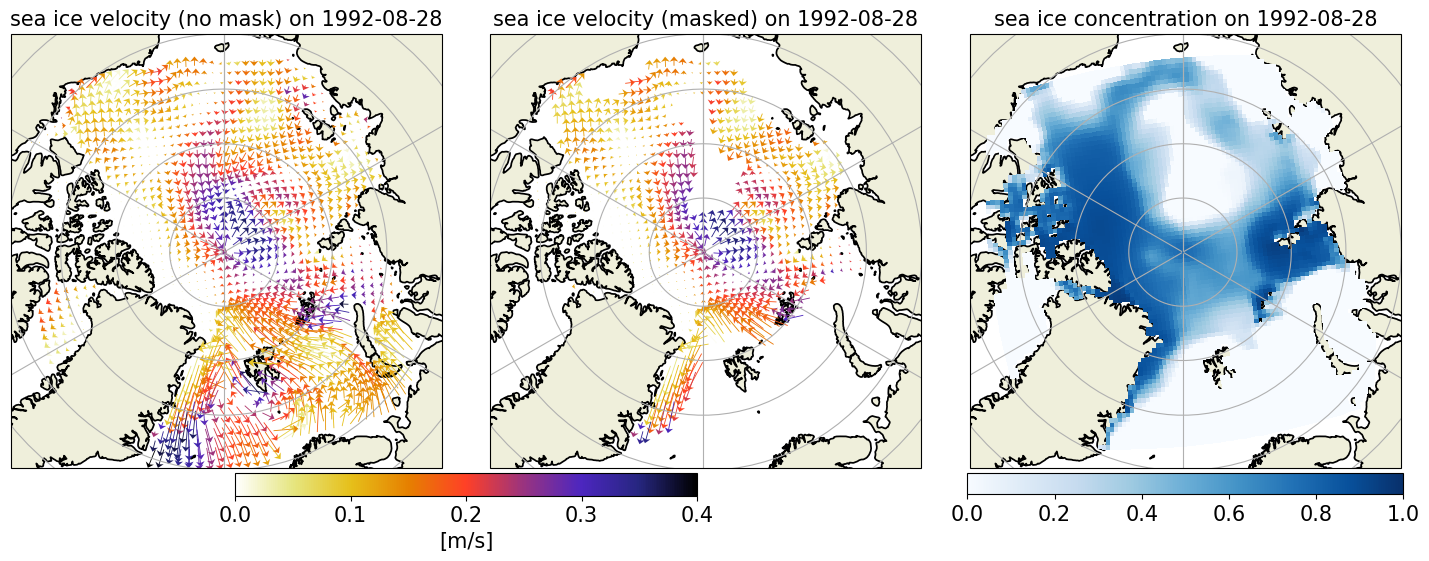

In [25]:
# Set up day and plot
T = 240
L = 15
F = 15
fig, axes = plt.subplots(1, 3, figsize=(18, 6), 
                         subplot_kw={'projection': ccrs.Stereographic(central_latitude=90)}, 
                         gridspec_kw={'wspace': 0.1})

# Shared settings
vector_crs = ccrs.PlateCarree()
extent = [-180, 180, 70, 90]
norm = mcolors.Normalize(vmin=0, vmax=0.4)
date_str = str(ecco_ds.time[T].values)[:10]
titles = [f'sea ice velocity (no mask) on {date_str}', f'sea ice velocity (masked) on {date_str}', f'sea ice concentration on {date_str}']
colormaps = ['CMRmap_r', 'CMRmap_r', 'Blues']
velocity_data = [(ecco_ds['u_lambda'], ecco_ds['v_phi'], ecco_ds['c']), 
                 (ecco_ds['uvel_masked'], ecco_ds['vvel_masked'], ecco_ds['c_masked'])]

# Plot function for velocity fields (Took slight advice from ChatGPT)
for ax, (u, v, color_data), title, cmap in zip(axes[:2], velocity_data, titles[:2], colormaps[:2]):
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    h = ax.quiver(
        ecco_ds.XC.isel(tile=6).values[::2, ::2].ravel(),
        ecco_ds.YC.isel(tile=6).values[::2, ::2].ravel(),
        u.isel(time=0, tile=6).values[::2, ::2].ravel(),
        v.isel(time=0, tile=6).values[::2, ::2].ravel(),
        color_data.isel(time=T, tile=6).values[::2, ::2].ravel(),
        scale=5, transform=vector_crs, width=0.002, cmap=cmap, headwidth=10, headlength=6, norm=norm
    )
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', linewidth=1.25)
    ax.gridlines(draw_labels=False)
    ax.set_title(title, fontsize=F)

# Third plot for SIarea with adjusted color range
axes[2].set_extent(extent, crs=ccrs.PlateCarree())
si_area_plot = axes[2].pcolormesh(
    ecco_ds.XC.isel(tile=6).values, 
    ecco_ds.YC.isel(tile=6).values,
    ecco_ds['SIarea'].isel(time=T, tile=6).values,
    transform=vector_crs, cmap='Blues', vmin=0, vmax=1
)
axes[2].add_feature(cfeature.LAND, zorder=0, edgecolor='black', linewidth=1.25)
axes[2].gridlines(draw_labels=False)
axes[2].set_title(titles[2], fontsize=F)

# Colorbar for subplots 1 and 2
cbar1 = fig.colorbar(h, ax=axes[:2], orientation='horizontal', fraction=0.05, pad=0.01)
cbar1.set_label('[m/s]', fontsize=F)
cbar1.ax.tick_params(labelsize=L)

# Separate colorbar for subplot 3 without label
cbar2 = fig.colorbar(si_area_plot, ax=axes[2], orientation='horizontal', fraction=0.05, pad=0.01)
cbar2.ax.tick_params(labelsize=L)

plt.show()


In [26]:
ecco_ds.close()

## Seasonal division

<div class="alert alert-block alert-info">
<b>Step 3:</b> Group the entire dataset into season and plot their seasonal variability.</div>

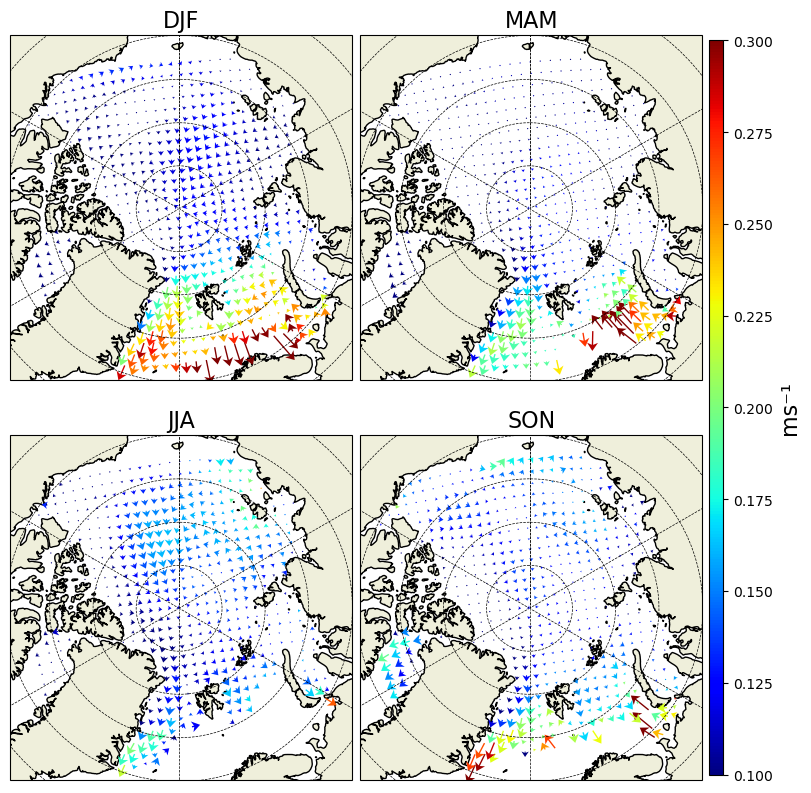

In [27]:
# 1. Group 'c_masked', 'uvel_masked', and 'vvel_masked' by season and compute mean
c_seasoned = ecco_ds.c_masked.groupby('time.season').mean(dim='time')
u_seasoned = ecco_ds.uvel_masked.groupby('time.season').mean(dim='time')
v_seasoned = ecco_ds.vvel_masked.groupby('time.season').mean(dim='time')

# 2. Define the seasons in order
seasons = ['DJF', 'MAM', 'JJA', 'SON']

# 3. Set tile number
tile = 6

# 4. Set up the figure and axes with a 2x2 grid and reduced padding
fig, axes = plt.subplots(2, 2, figsize=(8, 8), 
                         subplot_kw={'projection': ccrs.Stereographic(central_latitude=90)}, 
                         constrained_layout=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# 5. Define shared color normalization based on all seasons
norm = mcolors.Normalize(vmin=0.1, vmax=0.3)

# 6. Loop through each season to create quiver plots 
#(took help from ChatGPT to run it in for loop)
for ax, season in zip(axes, seasons):
    # Set map extent and add land features
    ax.set_extent([-180, 180, 70, 90], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', linewidth=1)
    ax.gridlines(draw_labels=False, linewidth=0.5, linestyle='--',color='black')
    
    # Subsample data for clearer quiver arrows
    step = 3  # Adjust the step for quiver density
    X = ecco_ds['XC'].sel(tile=tile).values[::step, ::step]
    Y = ecco_ds['YC'].sel(tile=tile).values[::step, ::step]
    U = u_seasoned.sel(season=season, tile=tile).values[::step, ::step]
    V = v_seasoned.sel(season=season, tile=tile).values[::step, ::step]
    C = c_seasoned.sel(season=season, tile=tile).values[::step, ::step]
    
    # Plot quiver with color based on 'c_seasoned'
    q = ax.quiver(X, Y, U, V, C, transform=ccrs.PlateCarree(), cmap='jet',
                 scale=5, width=0.004, headwidth=8, headlength=6, norm=norm)
    
    # Set subplot title
    ax.set_title(season, fontsize=16)
    
    # Remove axis labels and ticks
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])

# 7. Add a single colorbar to the right of all subplots spanning the figure's height
cbar = fig.colorbar(q, ax=axes, orientation='vertical', fraction=0.02, pad=0.01, aspect=53)
cbar.set_label('ms⁻¹', fontsize=16)


# 8. Display the plot
plt.show()


<hr>

# Section 3

<span style="font-family:Arial">The main goal of this section is to load the ERA-Interim wind velocity data and compute the <span style="color:red">complex correlation</span> between sea ice velocity and surface wind fields. The resulting plots are anticipated to provide valuable insights into the spatial and seasonal patterns of wind influence on the model's representation of sea ice.</span>

- [ ] Load one year ERA Interim daily mean wind velocity data
- [ ] Write down code to calculate <span style="color:red">complex correlation</span>
- [ ] Plot maps of <span style="color:red">complex correlation</span> for different seasons
- [ ] Plot maps of <span style="color:blue">transfer coefficient</span> for different seasons


<hr>

# Section 4

Key goals for this section is to describe the findings from section 3 using the sea ice thickness spatial variability. We expect that the areas with thinner sea ice with show higher trasnfer

# Check variable size

<div class="alert alert-block alert-danger">
<b>Troubleshoot:</b> In case you need to know which varibales are causing havoc (huge size), you can follow the steps and delete the big size variables.
</div>

To run this code, you firts need to install pympler. In a notebook cell, just type `%pip install pympler`. It will install it automatically. And then, write down the block of codes.

In [31]:
import sys
sys.path.append('/Users/aahmed78/')
# In case you don't have it installed, install it simply by just running it here.
# %pip install pympler pandas
import memory_utils
# List and sort variables by memory usage
# top_n=10 means it is now displaying the top 10 largest size variable
memory_utils.list_sorted_vars(globals(), top_n=20)


           Variable  Size (bytes)
0               Out    2644174752
1           ecco_ds    2505860192
2             v_phi     309180608
3          u_lambda     309180608
4                 c     308318528
5   nan_land_mask_W      42143048
6   nan_land_mask_S      42143024
7                ax       5127576
8                 q       5097696
9              cbar       5074768
10              fig       4928184
11       v_seasoned       4235960
12       u_seasoned       4235944
13       c_seasoned       4235360
14                V       3377040
15                C       3377040
16                U       3377040
17                f       1836056
18                X        425040
19                Y        425040


In [29]:
del velocity_data, vec_u_to_ij, u, v, color_data, si_area_plot, u_x, v_y, h, cbar1, cbar2